In [1]:
%reset

import numpy as np
import pickle as pk
import matplotlib
import matplotlib.pyplot as pl
from astropy import units
from astropy import constants
# import matplotlib
from astropy.io import fits
import sys, os
import dill
# %pylab inline

# Color = ['#0072b1','#009d73','#d45e00','k', 'grey','yellow']

Color = ['k', '#000075', '#a9a9a9','#9A6324', '#808000','#aaffc3', '#fffac8'  ,'#800000', '#ffd8b1',]


font = {'size'   : 18}
matplotlib.rc('font', **font)
# # Latex stuff
# pl.rc('text', usetex=True)
pl.rc('font', family='serif')
%load_ext autoreload
%autoreload 2
# %matplotlib inline


Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [95]:
os.environ['COSMOSIS_SRC_DIR'] = '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis'

# sys.path.insert(0, '../../../helper/')
sys.path.insert(0, '../cosmosis_code/')

from pressure import *
from get_theory_interface import *


In [96]:
def replace_values(params_dict, pressure_params_orig, sec_name='theory_yx'):
    pressure_params_dict = copy.deepcopy(pressure_params_orig)
    for key in params_dict.keys():
        key_sp = key.split('--')
        if key_sp[0] == sec_name:
            param_val = key_sp[1]
            for pressure_keys in pressure_params_dict.keys():
                if param_val == pressure_keys.lower():
                    pressure_params_dict[pressure_keys] = params_dict[key]

    return pressure_params_dict

def weighted_percentile(data_mat, percents, weights=None):
    weighted_mat = np.zeros(data_mat.shape[1])
    for mj in range(data_mat.shape[1]):
        data = data_mat[:, mj]
        if weights is None:
            return np.percentile(data, percents)
        ind=np.argsort(data)
        d=data[ind]
        w=weights[ind]
        p=1.*w.cumsum()/w.sum()*100
        y=np.interp(percents, p, d)
        weighted_mat[mj] = y
    return weighted_mat



In [97]:
z = 0.25
h = 0.6774
# percentiles = [2.5, 97.5]
percentiles = [16.0, 84.0]

class makeplot:
    def __init__(self, params_files_dir,params_file , params_def_file):
        
        ini_info = read_ini(params_files_dir + params_file, ini_def=params_files_dir + params_def_file)
        other_params_dict = copy.deepcopy(ini_info['other_params_dict'])
        cosmo_params_dict = copy.deepcopy(ini_info['cosmo_params_dict'])
        pressure_params_dict = copy.deepcopy(ini_info['pressure_params_dict'])
        hod_params_dict = copy.deepcopy(ini_info['hod_params_dict'])
        cosmology.addCosmology('mock_cosmo', cosmo_params_dict)
        self.cosmo_colossus = cosmology.setCosmology('mock_cosmo')
        #        self.cosmo_colossus = cosmology.setCosmology('planck18')
        h = cosmo_params_dict['H0'] / 100.
        cosmo_func = cosmodef.mynew_cosmo(h, cosmo_params_dict['Om0'], cosmo_params_dict['Ob0'], cosmo_params_dict['ns'], cosmo_params_dict['sigma8'])  
        self.cosmo = cosmo_func
        self.M_array, self.z_array, self.x_array = other_params_dict['M_array'], other_params_dict['z_array'], other_params_dict[
        'x_array']
        self.verbose = other_params_dict['verbose']
        self.nm, self.nz = len(self.M_array), len(self.z_array)
        M_mat_mdef = np.tile(self.M_array.reshape(1, self.nm), (self.nz, 1))
        self.M_mat = M_mat_mdef
        self.Pressure_fid = Pressure(cosmo_params_dict, pressure_params_dict, other_params_dict)
        other_params_dict['pressure_fid'] = pressure_params_dict
        self.cosmo_params_dict, self.pressure_params_dict, self.other_params_dict = cosmo_params_dict, pressure_params_dict, other_params_dict
    

        
    def collect_YM(self,chain_file=None, nsamps=100, M_min = 1e12, M_max = 10**15.3, z=0.25, numM = 20):
                
        M_array_500c = np.logspace(np.log10(M_min), np.log10(M_max), num=numM)
        
        pressure = Pressure(self.cosmo_params_dict, self.pressure_params_dict, self.other_params_dict)        
        YM_fid = np.zeros(numM)
        
        for mi in range(numM):
            YM_fid[mi] = pressure.get_Y500sph_singleMz(M_array_500c[mi], z, do_fast=False)
        
        
        if chain_file is not None:
            infile = open(chain_file, 'r')
            first_line = infile.readline()

            data = np.loadtxt(chain_file)
            nsample = nsamps

            data_params = data[-nsample:,:-4]
            weights = data[-nsample:,-1]

            all_params = first_line.split()[:-4]
            all_params[0] = all_params[0].split('#')[1]

            integratedY_mat = np.zeros((nsample,numM))
    #         numM = len(M_array_500c)
            for pi in range(nsample):
                params_dict = {}
                for jp in range(len(all_params)):
                    params_dict[all_params[jp]] = data_params[pi,jp]
                cosmo_params, pressure_params, other_params = copy.deepcopy(
                    self.cosmo_params_dict), copy.deepcopy(self.pressure_params_dict), copy.deepcopy(self.other_params_dict)

                pressure_params = replace_values(params_dict, pressure_params)
                other_params['pressure_fid'] = pressure_params
    #             print(pressure_params)
                pressure = Pressure(cosmo_params, pressure_params, other_params)

                for mi in range(numM):
                    integratedY = pressure.get_Y500sph_singleMz(M_array_500c[mi], z, do_fast=False)
                    integratedY_mat[pi,mi] = integratedY               

            YM_low = weighted_percentile(integratedY_mat, percentiles[0], weights=weights)
            YM_high = weighted_percentile(integratedY_mat, percentiles[1], weights=weights)
            return M_array_500c, YM_low, YM_high, YM_fid, integratedY_mat
        
        else:
            return M_array_500c, YM_fid
        
            
    def collect_Pe_mat(self,chain_file=None, nsamps=100, x_min = 0.1, x_max = 3, z=0.25, M=1e13, numx = 20):
            x_array = np.logspace(np.log10(x_min), np.log10(x_max), num=numx)
            pressure = Pressure(self.cosmo_params_dict, self.pressure_params_dict, self.other_params_dict)
            rhoDelta = pressure.pressure_model_delta * pressure.cosmo_colossus.rho_c(z) * (1000 ** 3)
            R_mat = np.array([[np.power(3 * M / (4 * np.pi * rhoDelta), 1. / 3.)]])
            Pe_fid = pressure.get_Pe_mat(np.array([[M]]), x_array, np.array([z]), R_mat)
            
            if chain_file is not None:
                infile = open(chain_file, 'r')
                first_line = infile.readline()

                data = np.loadtxt(chain_file)
                nsample = nsamps

                data_params = data[-nsample:,:-4]
                weights = data[-nsample:,-1]

                all_params = first_line.split()[:-4]
                all_params[0] = all_params[0].split('#')[1]
                
                Pe_mat = np.zeros((nsample,numx))
        #         numM = len(M_array_500c)
                for pi in range(nsample):
                    params_dict = {}
                    for jp in range(len(all_params)):
                        params_dict[all_params[jp]] = data_params[pi,jp]
                    cosmo_params, pressure_params, other_params = copy.deepcopy(
                        self.cosmo_params_dict), copy.deepcopy(self.pressure_params_dict), copy.deepcopy(self.other_params_dict)

                    pressure_params = replace_values(params_dict, pressure_params)
                    other_params['pressure_fid'] = pressure_params
        #             print(pressure_params)
                    pressure = Pressure(cosmo_params, pressure_params, other_params)
                    Pe_mat[pi,:] = pressure.get_Pe_mat(np.array([[M]]), x_array, np.array([z]), R_mat)

                Pe_low = weighted_percentile(Pe_mat, percentiles[0], weights=weights)
                Pe_high = weighted_percentile(Pe_mat, percentiles[1], weights=weights)
            
                return x_array, Pe_low, Pe_high, Pe_fid
            else:
                return x_array, Pe_fid


            

In [98]:
pf_dir = os.environ['COSMOSIS_SRC_DIR'] + '/ACTxDESY3/src/params_files/'
pf_main = 'params_des_kk_ky_planck_act_y3_beamed.ini'
pf_def = 'params_default.ini'
mp = makeplot(pf_dir, pf_main, pf_def)


Note: redshifts have been re-sorted (earliest first)


In [99]:
chain_f = '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/chains/chain_sz_shear_planckpactxdesy3_v0p4_broken_wide.txt'  
M_array, YM_low, YM_high, YM_fid, integratedY_mat = mp.collect_YM(chain_file=chain_f, z=0.25)




In [100]:
chain_f = '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/chains/chain_sz_shear_planckxdesy3_v0p4_broken_wide.txt'  
M_array, YM_low_pl, YM_high_pl, YM_fid, integratedY_mat = mp.collect_YM(chain_file=chain_f, z=0.25)




In [101]:
ym_agn8_data = np.genfromtxt('YM_AGN8.dat', delimiter = ',')
ym_agn85_data = np.genfromtxt('YM_AGN8.5.dat', delimiter = ',')
ym_ref_data = np.genfromtxt('YM_REF.dat', delimiter = ',')



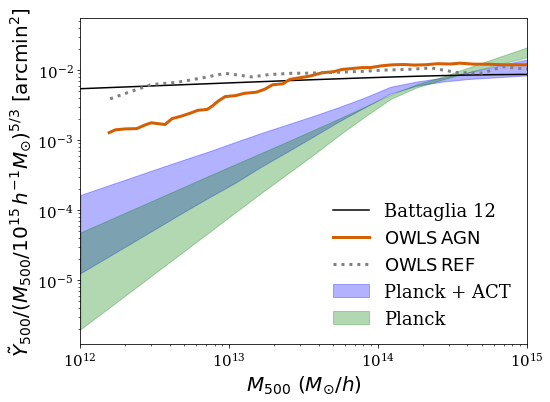

In [102]:
pl.rc('text', usetex=False)

z = 0.25
h = 0.6731
# percentiles = [2.5, 97.5]
percentiles = [16.0, 84.0]
numM = 300
nsample = 200
nsamps = nsample

colors = ['blue']
alpha_list = [0.3, 0.3, 0.3, 0.2, 0.2, 0.2]
labels = [r'Data']
linestyles = ['-']


fig, ax = pl.subplots(1, 1, figsize=(8, 6))

# print "percentiles = ", percentiles
for ii in range(1):
    if (0):
        scaling = 1.0
    else:
        scaling = (M_array/1.0e15)**(-5./3.)        
#     if labels[ii] is not None:
# #         print "plotting"
#         ax.fill_between(M_array, YM_low*scaling, YM_high*scaling, color=colors[ii], alpha=alpha_list[ii], label = labels[ii])
#     else:
# #         print "plotting"            
#         ax.fill_between(M_array, YM_low*scaling, YM_high*scaling, color=colors[ii], alpha=alpha_list[ii], label = labels[ii])
    
    
ax.fill_between(M_array, YM_low*scaling, YM_high*scaling, color='blue', alpha=alpha_list[0], label = 'Planck + ACT')
ax.fill_between(M_array, YM_low_pl*scaling, YM_high_pl*scaling, color='green', alpha=alpha_list[0], label = 'Planck')
ax.plot(M_array, YM_fid*scaling, color='k', alpha=1.0, label = 'Battaglia 12')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$M_{\rm 500} \ (M_{\odot}/h)$', size=20)
# ax.set_ylabel(r'$ \tilde{Y}_{500} / M^{5/3}_{500} \ [\rm{arcmin}^2 (h/ M_{\odot})^{5/3} ]$', size=20)
ax.set_ylabel(r'$ \tilde{Y}_{500} / (M_{500}/10^{15} \,h^{-1} M_{\odot} )^{5/3} \ [\rm{arcmin}^2 ]$', size=20)


ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)

Colors = ['#0072b1','#009d73','#d45e00','k', 'grey','yellow']

if (0):
    ax.plot(ym_agn8_data[:,0]*h, ym_agn8_data[:,1], label = r'${\rm OWLS \, AGN}$', lw = 2, color  = Colors[0])
#     ax.plot(ym_agn85_data[:,0]*h, ym_agn85_data[:,1], label =  r'${\rm AGN8.5}$', lw = 2, ls = 'dashed', color = Colors[1])
    ax.plot(ym_ref_data[:,0]*h, ym_ref_data[:,1], label =  r'${\rm OWLS \, REF}$', lw = 2, ls = 'dotted', color = Colors[2])
if (1):
    ax.plot(ym_agn8_data[:,0]*h, ym_agn8_data[:,1]/(ym_agn8_data[:,0]*h/1.0e15)**(5./3.), label = r'${\rm OWLS \, AGN}$', lw = 3, color  = Colors[2])
#     ax.plot(ym_agn85_data[:,0]*h, ym_agn85_data[:,1]/(ym_agn85_data[:,0]*h/1.0e15)**(5/3.), label =  r'${\rm AGN8.5}$', lw = 3, ls = 'dashed', color = Colors[1])
    ax.plot(ym_ref_data[:,0]*h, ym_ref_data[:,1]/(ym_ref_data[:,0]*h/1.0e15)**(5./3.), label =  r'${\rm OWLS \, REF}$', lw = 3, ls = 'dotted', color = Colors[4])

ax.set_xlim((1.0e12, 1.0e15))
#ax.set_ylim((2.0e-8, 1.0e-2))
#ax.set_ylim((1.0e-29, 5.0e-27))


legend = ax.legend(fontsize=18, frameon=False, loc = 'lower right')




In [114]:
pf_dir = os.environ['COSMOSIS_SRC_DIR'] + '/ACTxDESY3/src/params_files/'
pf_main = 'params_des_kk_ky_plancky3_beamed_makeDV_OWLSAGN.ini'
pf_def = 'params_default.ini'
mp_agn = makeplot(pf_dir, pf_main, pf_def)

pf_dir = os.environ['COSMOSIS_SRC_DIR'] + '/ACTxDESY3/src/params_files/'
pf_main = 'params_des_kk_ky_plancky3_beamed_makeDV_OWLSRef.ini'
pf_def = 'params_default.ini'
mp_ref = makeplot(pf_dir, pf_main, pf_def)


pf_dir = os.environ['COSMOSIS_SRC_DIR'] + '/ACTxDESY3/src/params_files/'
pf_main = 'params_des_kk_ky_plancky3_beamed_makeDV_B12.ini'
pf_def = 'params_default.ini'
mp_b12 = makeplot(pf_dir, pf_main, pf_def)




Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


In [115]:
M_array, YM_agn = mp_agn.collect_YM()

M_array, YM_ref = mp_ref.collect_YM()

M_array, YM_b12 = mp_b12.collect_YM()




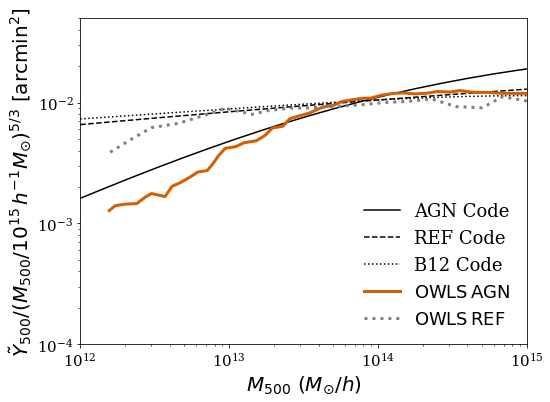

In [116]:
pl.rc('text', usetex=False)

scaling = (M_array/1.0e15)**(-5./3.)     
# scaling = 1.  
z = 0.25
h = 0.6731
# percentiles = [2.5, 97.5]
percentiles = [16.0, 84.0]
numM = 300
nsample = 200
nsamps = nsample

colors = ['blue']
alpha_list = [0.3, 0.3, 0.3, 0.2, 0.2, 0.2]
labels = [r'Data']
linestyles = ['-']


fig, ax = pl.subplots(1, 1, figsize=(8, 6))

ax.plot(M_array, YM_agn*scaling, color='k', alpha=1.0, label = 'AGN Code')
ax.plot(M_array, YM_ref*scaling, color='k', ls='--', alpha=1.0, label = 'REF Code')
ax.plot(M_array, YM_b12*scaling, color='k', ls=':', alpha=1.0, label = 'B12 Code')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$M_{\rm 500} \ (M_{\odot}/h)$', size=20)
# ax.set_ylabel(r'$ \tilde{Y}_{500} / M^{5/3}_{500} \ [\rm{arcmin}^2 (h/ M_{\odot})^{5/3} ]$', size=20)
ax.set_ylabel(r'$ \tilde{Y}_{500} / (M_{500}/10^{15} \,h^{-1} M_{\odot} )^{5/3} \ [\rm{arcmin}^2 ]$', size=20)


ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)

Colors = ['#0072b1','#009d73','#d45e00','k', 'grey','yellow']
# print(h)
if len(scaling) > 1:
    ax.plot(ym_agn8_data[:,0]*h, ym_agn8_data[:,1]/(ym_agn8_data[:,0]*h/1.0e15)**(5./3.), label = r'${\rm OWLS \, AGN}$', lw = 3, color  = Colors[2])
#     ax.plot(ym_agn85_data[:,0]*h, ym_agn85_data[:,1]/(ym_agn85_data[:,0]*h/1.0e15)**(5/3.), label =  r'${\rm AGN8.5}$', lw = 3, ls = 'dashed', color = Colors[1])
    ax.plot(ym_ref_data[:,0]*h, ym_ref_data[:,1]/(ym_ref_data[:,0]*h/1.0e15)**(5./3.), label =  r'${\rm OWLS \, REF}$', lw = 3, ls = 'dotted', color = Colors[4])

else:
    if (scaling == 1):
        ax.plot(ym_agn8_data[:,0]*h, ym_agn8_data[:,1], label = r'${\rm OWLS \, AGN}$', lw = 2, color  = Colors[0])
    #     ax.plot(ym_agn85_data[:,0]*h, ym_agn85_data[:,1], label =  r'${\rm AGN8.5}$', lw = 2, ls = 'dashed', color = Colors[1])
        ax.plot(ym_ref_data[:,0]*h, ym_ref_data[:,1], label =  r'${\rm OWLS \, REF}$', lw = 2, ls = 'dotted', color = Colors[2])

    
    
ax.set_xlim((1.0e12, 1.0e15))
ax.set_ylim((1.0e-4, 5.0e-2))
#ax.set_ylim((1.0e-29, 5.0e-27))


legend = ax.legend(fontsize=18, frameon=False, loc = 'lower right')






Text(0.1, 0.007, '$M = 10^{13}\\,M_{\\odot}/h, \\ z=0.25$')

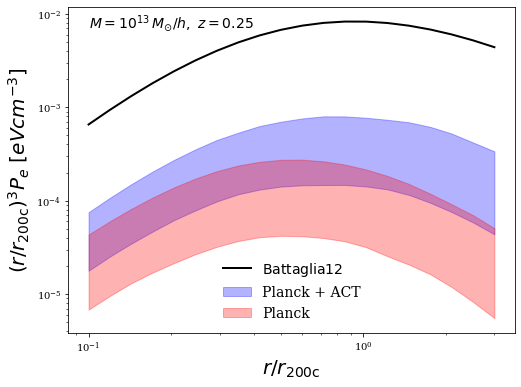

In [87]:
mass_labels = [r'$M = 10^{13}\,M_{\odot}/h, \ z=0.25$']

chain_f = '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/chains/chain_sz_shear_planckpactxdesy3_v0p4_broken_wide.txt'  
x_array, Pe_low, Pe_high, Pe_fid = mp.collect_Pe_mat(chain_f)

chain_f = '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/chains/chain_sz_shear_planckxdesy3_v0p4_broken_wide.txt'  
x_array, Pe_low_pl, Pe_high_pl, Pe_fid_pl = mp.collect_Pe_mat(chain_f)

# x_array, Pe_agn = mp_agn.collect_Pe_mat()
# x_array, Pe_ref = mp_ref.collect_Pe_mat()

fig, ax = pl.subplots(1, 1, figsize=(8, 6))
ax.fill_between(x_array, (x_array**3)*Pe_low, (x_array**3)*Pe_high, color='blue', alpha=alpha_list[0], label = 'Planck + ACT')  
ax.fill_between(x_array, (x_array**3)*Pe_low_pl, (x_array**3)*Pe_high_pl, color='red', alpha=alpha_list[0], label = 'Planck') 
ax.plot(x_array,(x_array**3)*Pe_fid[0,0,:],color='k',label=r'${\rm Battaglia 12}$', lw=2)
# ax.plot(x_array,(x_array**3)*Pe_agn[0,0,:],color=Colors[0],label=r'${\rm OWLS \, AGN}$', lw=2)
# ax.plot(x_array,(x_array**3)*Pe_ref[0,0,:],color=Colors[2],label=r'${\rm OWLS \, REF}$',lw=2)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r/r_{\rm 200c}$', size=20)
# ax.set_ylabel(r'$ \tilde{Y}_{500} / M^{5/3}_{500} \ [\rm{arcmin}^2 (h/ M_{\odot})^{5/3} ]$', size=20)
ax.set_ylabel(r'$(r/r_{\rm 200c})^3 P_e$ $[eV cm^{-3}]$', size=20)

ax.legend(fontsize=14, frameon=False,loc='lower center')
ax.text(0.1,7e-3,mass_labels[0], fontsize = 14)




Text(0.1, 0.001, '$M = 10^{14}\\,M_{\\odot}/h, \\ z=0.25$')

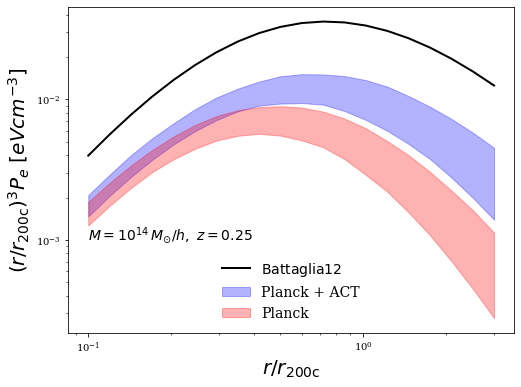

In [83]:
mass_labels = [r'$M = 10^{14}\,M_{\odot}/h, \ z=0.25$']

chain_f = '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/chains/chain_sz_shear_planckpactxdesy3_v0p4_broken_wide.txt'  
x_array, Pe_low, Pe_high, Pe_fid = mp.collect_Pe_mat(chain_f, z=0.25, M=1e14)

chain_f = '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/chains/chain_sz_shear_planckxdesy3_v0p4_broken_wide.txt'  
x_array, Pe_low_pl, Pe_high_pl, Pe_fid_pl = mp.collect_Pe_mat(chain_f, z=0.25, M=1e14)

# x_array, Pe_agn = mp_agn.collect_Pe_mat(z=0.25, M=1e14)
# x_array, Pe_ref = mp_ref.collect_Pe_mat(z=0.25, M=1e14)

fig, ax = pl.subplots(1, 1, figsize=(8, 6))
ax.fill_between(x_array, (x_array**3)*Pe_low, (x_array**3)*Pe_high, color='blue', alpha=alpha_list[0], label = 'Planck + ACT')  
ax.fill_between(x_array, (x_array**3)*Pe_low_pl, (x_array**3)*Pe_high_pl, color='red', alpha=alpha_list[0], label = 'Planck') 

ax.plot(x_array,(x_array**3)*Pe_fid[0,0,:],color='k',label=r'${\rm Battaglia 12}$', lw=2)
# ax.plot(x_array,(x_array**3)*Pe_agn[0,0,:],color=Colors[0],label=r'${\rm OWLS \, AGN}$', lw=2)
# ax.plot(x_array,(x_array**3)*Pe_ref[0,0,:],color=Colors[2],label=r'${\rm OWLS \, REF}$',lw=2)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r/r_{\rm 200c}$', size=20)
# ax.set_ylabel(r'$ \tilde{Y}_{500} / M^{5/3}_{500} \ [\rm{arcmin}^2 (h/ M_{\odot})^{5/3} ]$', size=20)
ax.set_ylabel(r'$(r/r_{\rm 200c})^3 P_e$ $[eV cm^{-3}]$', size=20)

ax.legend(fontsize=14, frameon=False,loc='lower center')
ax.text(0.1,1e-3,mass_labels[0], fontsize = 14)




Text(0.1, 0.001, '$M = 10^{14.5}\\,M_{\\odot}/h, \\ z=0.25$')

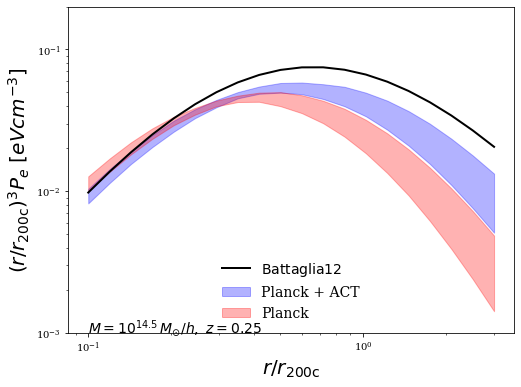

In [24]:
mass_labels = [r'$M = 10^{14.5}\,M_{\odot}/h, \ z=0.25$']

chain_f = '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/chains/chain_sz_shear_planckpactxdesy3_v0p4_broken_wide.txt'  
x_array, Pe_low, Pe_high, Pe_fid = mp.collect_Pe_mat(chain_f, z=0.25, M=10**14.5)

chain_f = '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/chains/chain_sz_shear_planckxdesy3_v0p4_broken_wide.txt'  
x_array, Pe_low_pl, Pe_high_pl, Pe_fid_pl = mp.collect_Pe_mat(chain_f, z=0.25, M=10**14.5)

# x_array, Pe_agn = mp_agn.collect_Pe_mat(z=0.25, M=1e14)
# x_array, Pe_ref = mp_ref.collect_Pe_mat(z=0.25, M=1e14)

fig, ax = pl.subplots(1, 1, figsize=(8, 6))
ax.fill_between(x_array, (x_array**3)*Pe_low, (x_array**3)*Pe_high, color='blue', alpha=alpha_list[0], label = 'Planck + ACT')  
ax.fill_between(x_array, (x_array**3)*Pe_low_pl, (x_array**3)*Pe_high_pl, color='red', alpha=alpha_list[0], label = 'Planck') 

ax.plot(x_array,(x_array**3)*Pe_fid[0,0,:],color='k',label=r'${\rm Battaglia 12}$', lw=2)
# ax.plot(x_array,(x_array**3)*Pe_agn[0,0,:],color=Colors[0],label=r'${\rm OWLS \, AGN}$', lw=2)
# ax.plot(x_array,(x_array**3)*Pe_ref[0,0,:],color=Colors[2],label=r'${\rm OWLS \, REF}$',lw=2)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r/r_{\rm 200c}$', size=20)
# ax.set_ylabel(r'$ \tilde{Y}_{500} / M^{5/3}_{500} \ [\rm{arcmin}^2 (h/ M_{\odot})^{5/3} ]$', size=20)
ax.set_ylabel(r'$(r/r_{\rm 200c})^3 P_e$ $[eV cm^{-3}]$', size=20)
ax.set_ylim(1e-3,2e-1)
ax.legend(fontsize=14, frameon=False,loc='lower center')
ax.text(0.1,1e-3,mass_labels[0], fontsize = 14)



